In [ ]:
%pip install deeptrack==0.11.3

import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
plt.style.use('default')

In [3]:
IMAGE_SIZE = 128
SAMPLE_THICKNESS = 300

In [4]:
particle = dt.MieSphere(
    position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2, #lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * IMAGE_SIZE - IMAGE_SIZE / 2,
    z = lambda: np.random.uniform(-SAMPLE_THICKNESS / 2, SAMPLE_THICKNESS / 2),
    radius = lambda: (1e-7 + 3e-7 * np.random.rand()),
    refractive_index = lambda: np.random.rand() * 0.3 + 1.37,
    L = 8,
    position_unit = 'pixel'
)

In [5]:
HC = dt.HorizontalComa(coefficient= lambda c1: c1, c1 = 0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient= lambda c2: c2, c2 = 0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

CROP = dt.Lambda(crop, pupil_radius = 23)

optics = dt.Brightfield(
    NA = 1.3,
    resolution = 1.13e-6,
    wavelength= 635e-9,
    aperture_angle= 53.7 * 2 * np.pi / 360,
    polarization_angle= lambda: np.random.rand() * 2 * np.pi,
    magnification= 10,
    output_region= (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding= (64,) * 4,
    return_field = True,
    pupil = HC + VC + CROP
)

In [6]:
real_noise = dt.Gaussian(
    mu = 0,
    sigma = lambda level: np.random.rand() * 0.02
)

noise = real_noise + dt.Gaussian(
    mu = 0,
    sigma = lambda real_sigma: real_sigma * 0.03j,
    real_sigma = real_noise.sigma
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

In [7]:
dataset = optics(particle**1 + noise) + complex_to_float

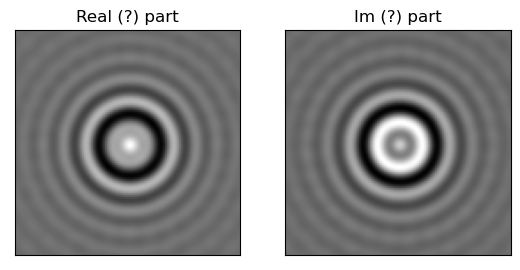

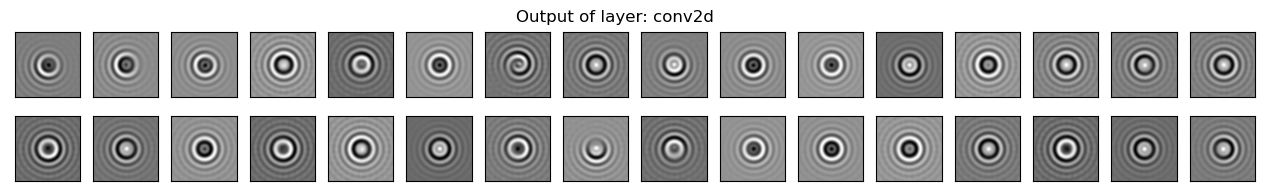

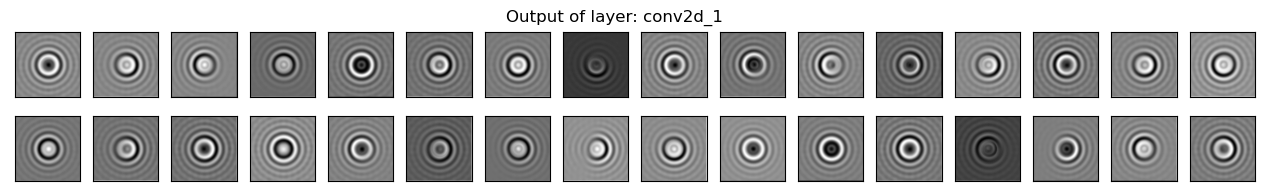

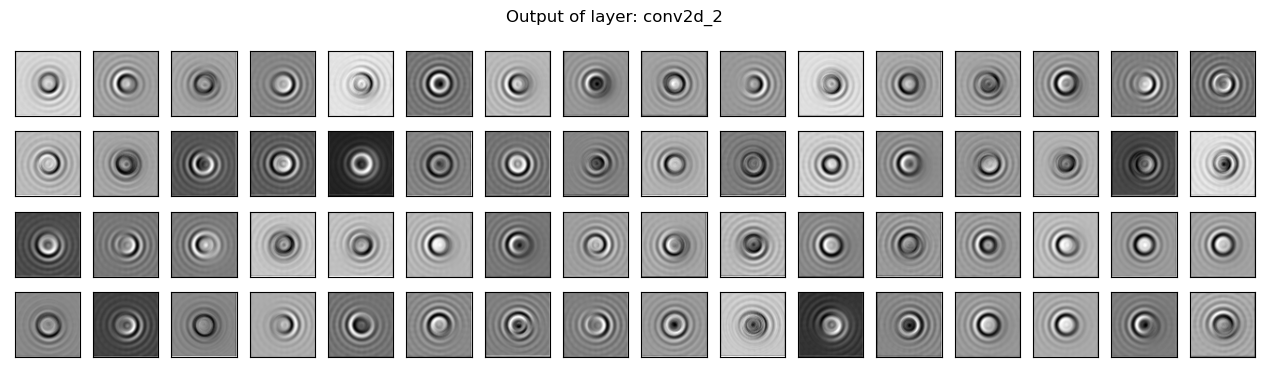

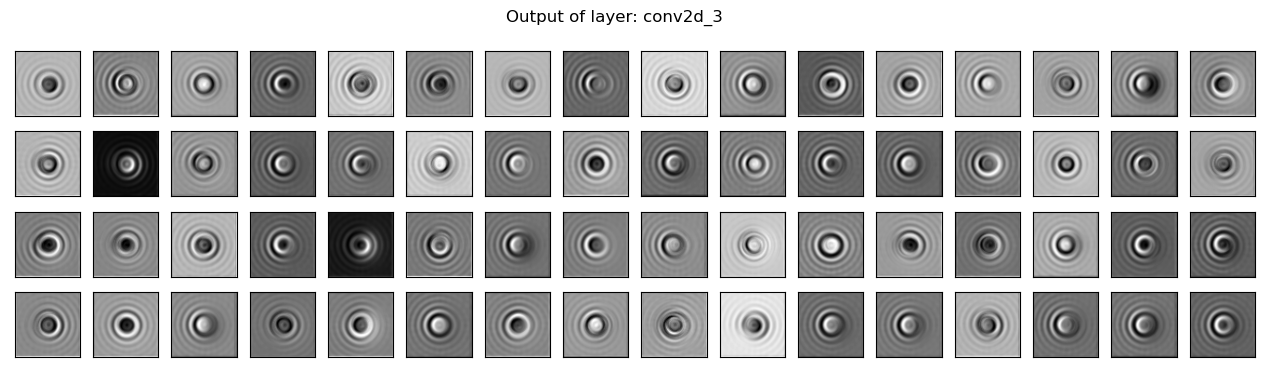

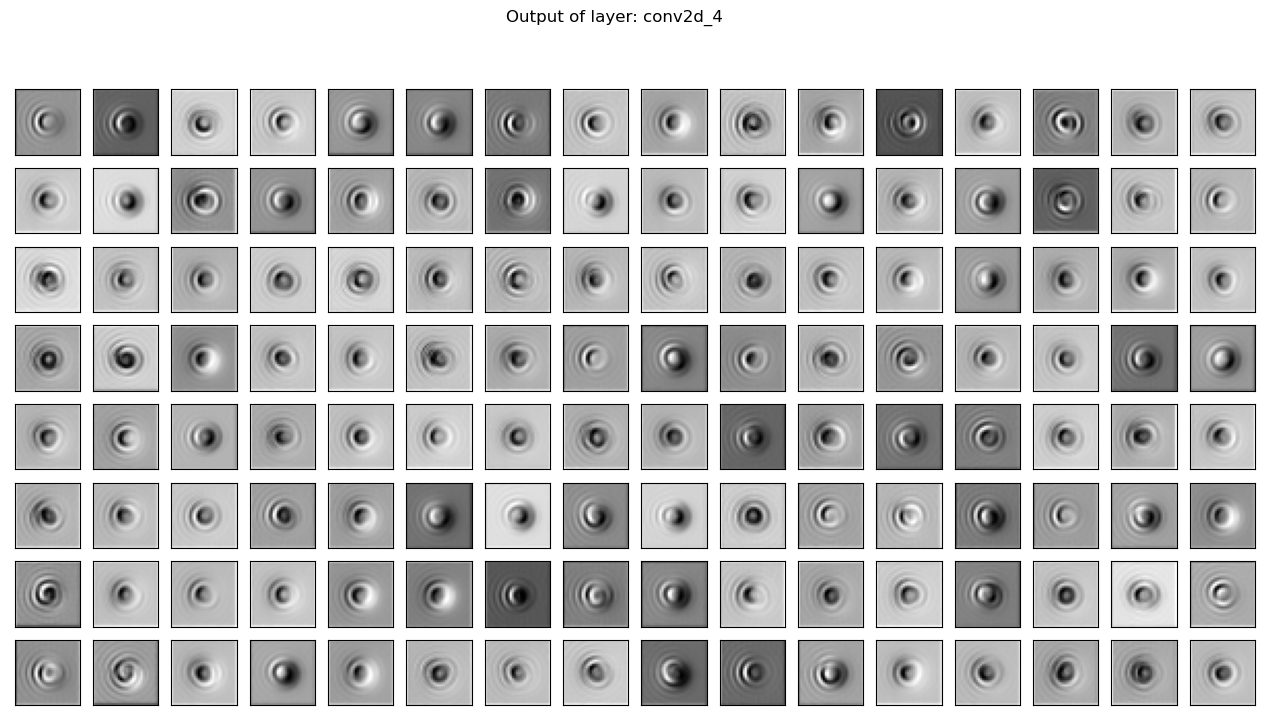

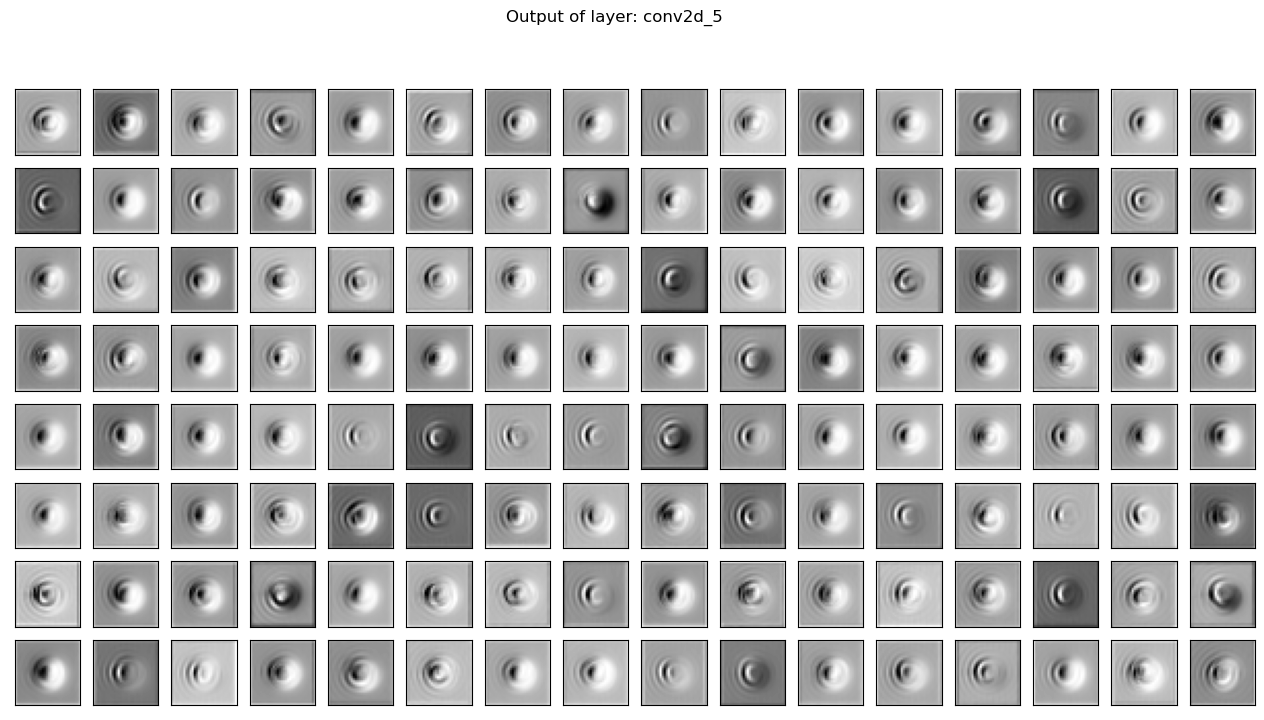

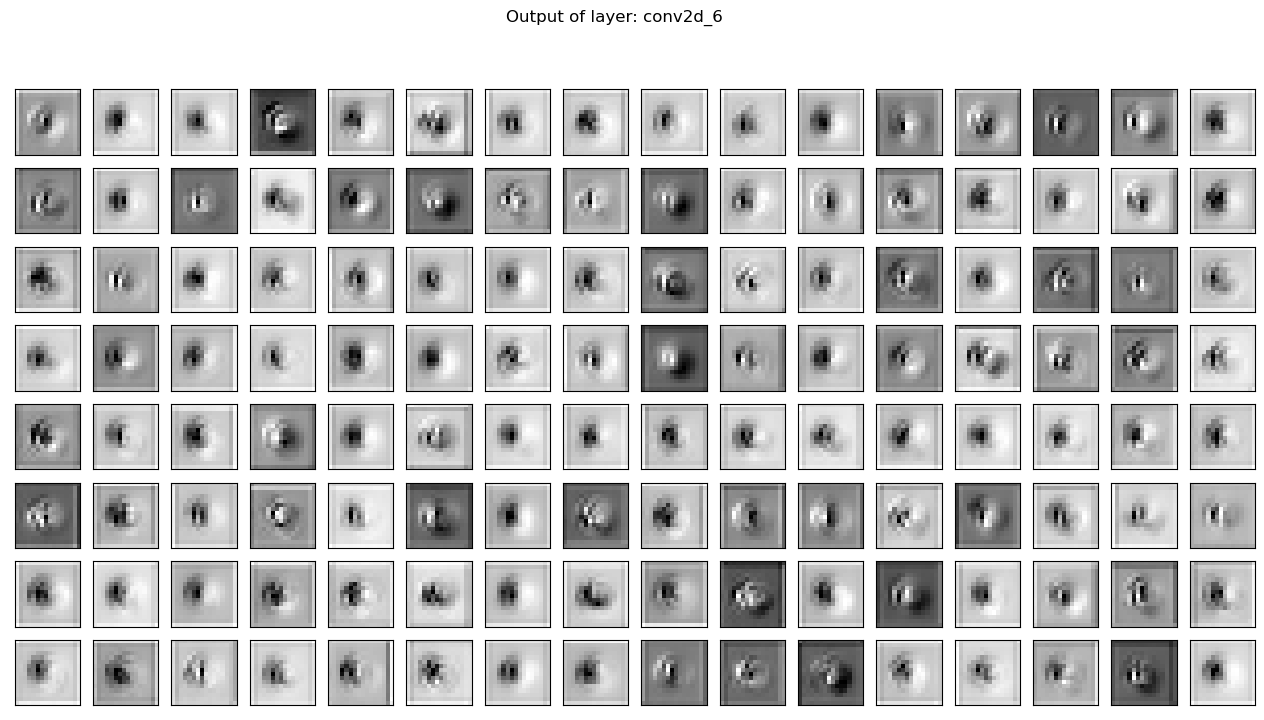

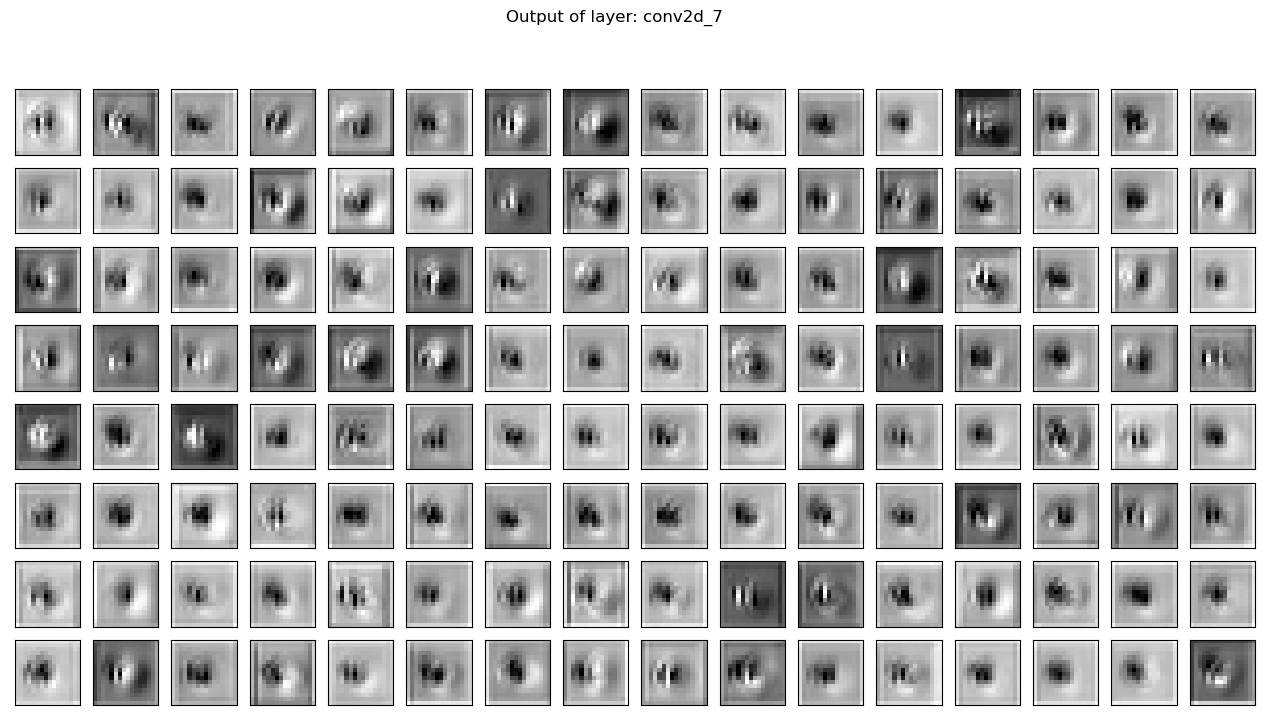

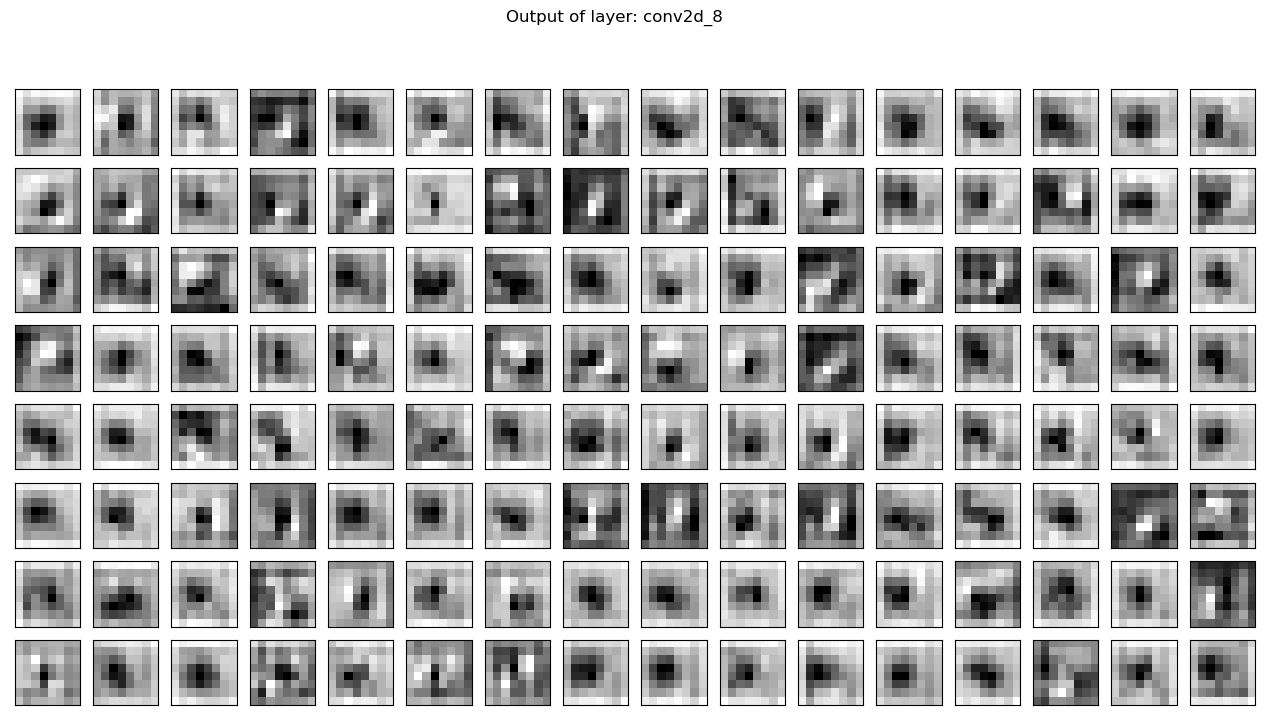

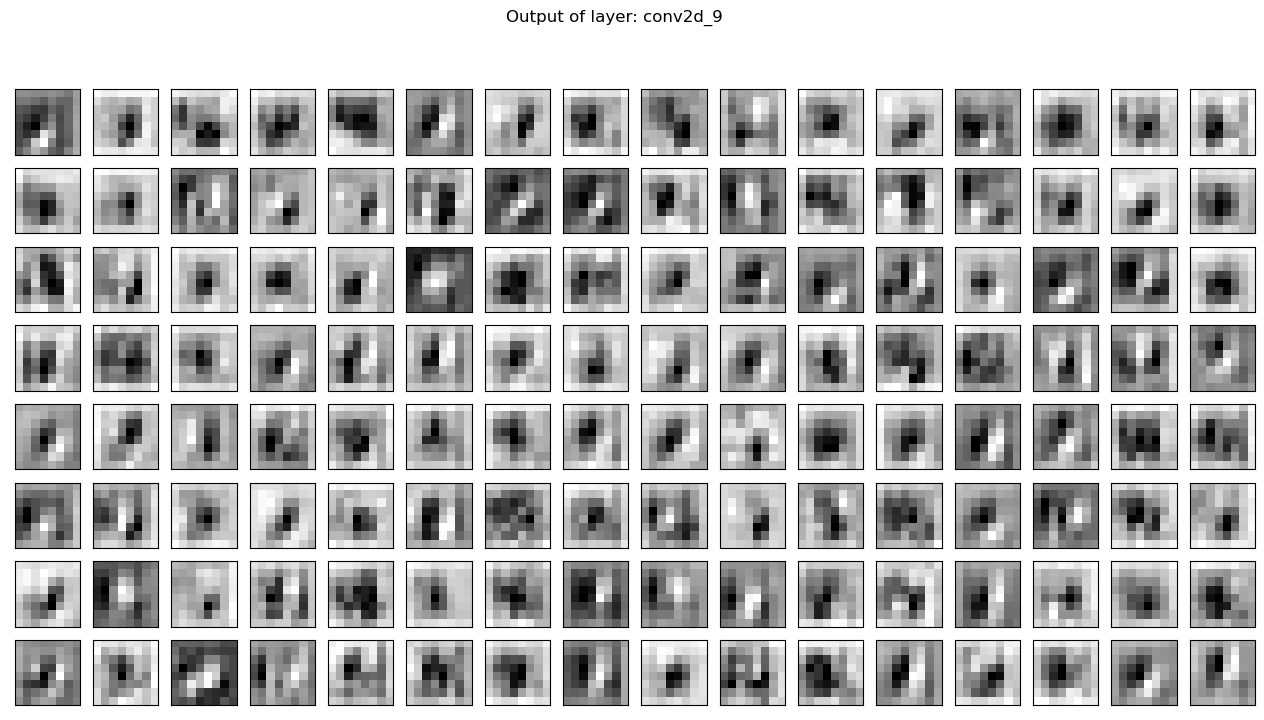

In [13]:
import visualize_feature_maps as vs
import keras

model = keras.models.load_model("sick_gpu_trained_killer_model")

dataset.update()
image_of_particle = dataset.resolve()

vs.visualize_feature_maps(model, image_of_particle, SUBPLOT_WIDTH=16, SUBPLOT_SIZE=1)